<a href="https://colab.research.google.com/github/hsallrounder/Cognitive-Analytics-Workshop-2/blob/main/Day3_ECG_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # load pandas
from matplotlib import pyplot as plt # load matplotlib's pyplot
import seaborn as sns
import tensorflow as tf # load tensorflow

In [2]:
# Source: https://drive.google.com/file/d/1yVf7vQzZdRZGv8veAZDEiQodHAh8qA_R/view?usp=drive_link
!gdown "1yVf7vQzZdRZGv8veAZDEiQodHAh8qA_R"

Downloading...
From: https://drive.google.com/uc?id=1yVf7vQzZdRZGv8veAZDEiQodHAh8qA_R
To: /content/ecg_tf_anomaly_detection.csv
100% 7.88M/7.88M [00:00<00:00, 24.5MB/s]


In [3]:
# read csv (text) file
with open('ecg_tf_anomaly_detection.csv',mode='r') as ecg_file_object:
  raw_ecg_data:list=ecg_file_object.readlines()# read all lines and return as list of lines
for index in range(len(raw_ecg_data)):# get index of value in list
  # Get a sample from list and overwrite it with cleaned values. To clean sample
  # remove '\n' from sample and split it by ',' .
  raw_ecg_data[index]=[float(value) for value in raw_ecg_data[index].replace('\n','').split(',')]
# seperate normal and abnormal ecg data
abnormal_ecg:list=[sample[:-1] for sample in raw_ecg_data if sample[-1]==0.0]# Abnormal ECG data
normal_ecg:list=[sample[:-1] for sample in raw_ecg_data if sample[-1]==1.0]# normal ECG data
# check the length of each sample - all samples must have the same length.
assert len(set([len(sample) for sample in abnormal_ecg]))==1,'All samples not have same length in abnormal ECG! '
assert len(set([len(sample) for sample in normal_ecg]))==1,'All samples not have same length normal ECG! '
print('Total samples in abnormal data:',len(abnormal_ecg))# print total number of samples
print('Total samples in normal data:',len(normal_ecg))# print total number of samples

Total samples in abnormal data: 2079
Total samples in normal data: 2919


In [4]:
abnormal_ecg_ds=tf.data.Dataset.from_tensor_slices(abnormal_ecg)# abnormal ecg dataset
normal_ecg_ds=tf.data.Dataset.from_tensor_slices(normal_ecg)# normal ecg dataset
print('Total samples in abnormal data:',abnormal_ecg_ds.cardinality().numpy())
print('Total samples in normal data:',normal_ecg_ds.cardinality().numpy())
print('Type of data in abnormal data:',abnormal_ecg_ds.element_spec)
print('Type of data in normal data:',normal_ecg_ds.element_spec)
buffer_size:int=1024 # buffer size (any value of 2^n)
batch_size:int=1024   # batch size
# Autotune data tensorflow data pipelines
abnormal_ecg_ds=abnormal_ecg_ds.cache().batch(batch_size=batch_size,
                  num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=buffer_size)
normal_ecg_ds=normal_ecg_ds.cache().batch(batch_size=batch_size,
                num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=buffer_size)

Total samples in abnormal data: 2079
Total samples in normal data: 2919
Type of data in abnormal data: TensorSpec(shape=(140,), dtype=tf.float32, name=None)
Type of data in normal data: TensorSpec(shape=(140,), dtype=tf.float32, name=None)


In [5]:
# make normalization layer
normalization_layer=tf.keras.layers.Normalization(name='normalization_layer')
normalization_layer.adapt(normal_ecg_ds)# make layer adapt on normal ECG data

In [6]:
total_samples:int=2919
train_ds=tf.data.Dataset.zip((normal_ecg_ds.take(int(total_samples*0.8/batch_size)),
                              normal_ecg_ds.take(int(total_samples*0.8/batch_size)),),
  name='training_ds').shuffle(buffer_size,reshuffle_each_iteration=True)
test_ds=tf.data.Dataset.zip((normal_ecg_ds.skip(int(total_samples*0.8/batch_size)),
                              normal_ecg_ds.skip(int(total_samples*0.8/batch_size)),),
                             name='test_ds')

In [7]:
# make build AutoEncoder to detect Abnormal ECGs
class ECGDectector(tf.keras.Model):

  # define class constructor
  def __init__(self,input_shape:tuple,normalization_layer=normalization_layer,
               name:str='ecg_dectector',**kwargs)->tf.keras.Model:

    ''' Returns the Autoencoder model for abnormal ECG detection .
          input_shape (tuple): input shape to model.
          name (name) : name of the model.
    '''

    super(ECGDectector,self).__init__(**kwargs,name=name)
    self.normalization_layer=normalization_layer
    self.encoder=tf.keras.Sequential([
        tf.keras.layers.Dense(32,activation='relu',input_shape=input_shape,
                              name='encoder_dense_32_01'),
        tf.keras.layers.Dense(16,activation='relu',name='encoder_dense_16_02'),
        tf.keras.layers.Dense(8,activation='relu',name='encoder_dense_8_03')
    ],name=self.name+'_encoder')
    self.decoder=tf.keras.Sequential([
        tf.keras.layers.Dense(16,activation='relu',
                              input_shape=self.encoder.output_shape[1:],
                              name='decoder_dense_8_04'),
        tf.keras.layers.Dense(32,activation='relu',name='decoder_dense_32_05'),
        tf.keras.layers.Dense(input_shape[0],activation=None,name='decoder_output_06'),
    ],name=self.name+'_decoder')


  # define model call method
  def call(self, inputs:tf.Tensor)->tf.Tensor:

    ''' define model call method '''

    # outputs=self.normalization_layer(inputs)
    # outputs=self.encoder(outputs)
    # outputs=self.decoder(outputs)
    # return outputs
    return self.decoder(self.encoder(self.normalization_layer(inputs)))

ecg_dectector=ECGDectector(input_shape=(140,))
_=ecg_dectector(tf.random.normal(shape=(batch_size,140)))# make model build
ecg_dectector.summary(line_length=120,positions=None,print_fn=None,
                      expand_nested=True,show_trainable=True,layer_range=None)

Model: "ecg_dectector"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 normalization_layer (Normalization)                  multiple                                        281               Y          
                                                                                                                                   
 ecg_dectector_encoder (Sequential)                   (None, 8)                                       5176              Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| encoder_dense_32_01 (Dense)                         (None, 32)                                      4512              Y         |
|                                                    

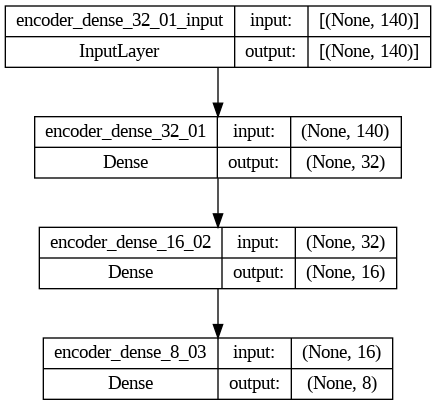

In [8]:
tf.keras.utils.plot_model(ecg_dectector.encoder,to_file='ecg_dectector_encoder.png',
                          show_shapes=True,show_dtype=False,
                          show_layer_names=True,expand_nested=True,
                          dpi=96,layer_range=None,show_layer_activations=False,
                          show_trainable=False)

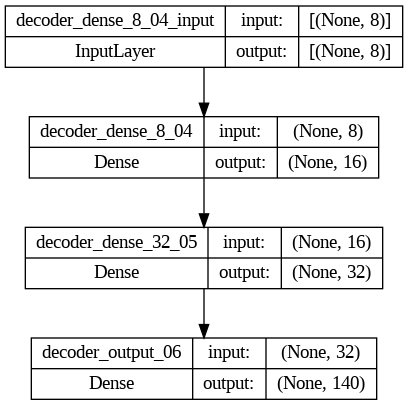

In [9]:
tf.keras.utils.plot_model(ecg_dectector.decoder,to_file='ecg_dectector_decoder.png',
                          show_shapes=True,show_dtype=False,
                          show_layer_names=True,expand_nested=True,
                          dpi=96,layer_range=None,show_layer_activations=False,
                          show_trainable=False)

In [10]:
ecg_dectector.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(),
                               tf.keras.metrics.MeanSquaredError()])

In [11]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0,patience=25,verbose=1,mode='auto',
    baseline=None,restore_best_weights=True,start_from_epoch=0)
history=ecg_dectector.fit(train_ds,batch_size=batch_size,epochs=1_000_000,
                          verbose=2,callbacks=[early_stopping],
                          validation_split=0,validation_data=test_ds,
                          shuffle=True,)

Epoch 1/1000000
2/2 - 3s - loss: 0.9953 - mean_absolute_error: 0.6692 - mean_squared_error: 0.9953 - val_loss: 0.9794 - val_mean_absolute_error: 0.6603 - val_mean_squared_error: 0.9794 - 3s/epoch - 1s/step
Epoch 2/1000000
2/2 - 0s - loss: 0.9767 - mean_absolute_error: 0.6599 - mean_squared_error: 0.9767 - val_loss: 0.9649 - val_mean_absolute_error: 0.6529 - val_mean_squared_error: 0.9649 - 135ms/epoch - 68ms/step
Epoch 3/1000000
2/2 - 0s - loss: 0.9620 - mean_absolute_error: 0.6522 - mean_squared_error: 0.9620 - val_loss: 0.9511 - val_mean_absolute_error: 0.6453 - val_mean_squared_error: 0.9511 - 86ms/epoch - 43ms/step
Epoch 4/1000000
2/2 - 0s - loss: 0.9475 - mean_absolute_error: 0.6441 - mean_squared_error: 0.9475 - val_loss: 0.9355 - val_mean_absolute_error: 0.6360 - val_mean_squared_error: 0.9355 - 94ms/epoch - 47ms/step
Epoch 5/1000000
2/2 - 0s - loss: 0.9310 - mean_absolute_error: 0.6344 - mean_squared_error: 0.9310 - val_loss: 0.9169 - val_mean_absolute_error: 0.6248 - val_mean_

In [12]:
pd.DataFrame(history.history).head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,0.995344,0.669169,0.995344,0.979426,0.660347,0.979426
1,0.976659,0.659864,0.976659,0.964945,0.652918,0.964945
2,0.961985,0.652232,0.961985,0.951146,0.645255,0.951146
3,0.947548,0.644129,0.947548,0.935460,0.636019,0.935460
4,0.931013,0.634369,0.931013,0.916903,0.624833,0.916903


In [13]:
pd.DataFrame(history.history).tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
1403,0.022237,0.100601,0.022237,0.023800,0.103365,0.023800
1404,0.022212,0.100519,0.022212,0.023724,0.103104,0.023724
1405,0.022148,0.100331,0.022148,0.023713,0.103000,0.023713
1406,0.022140,0.100259,0.022140,0.023726,0.103037,0.023726
1407,0.022176,0.100403,0.022176,0.023733,0.103112,0.023733


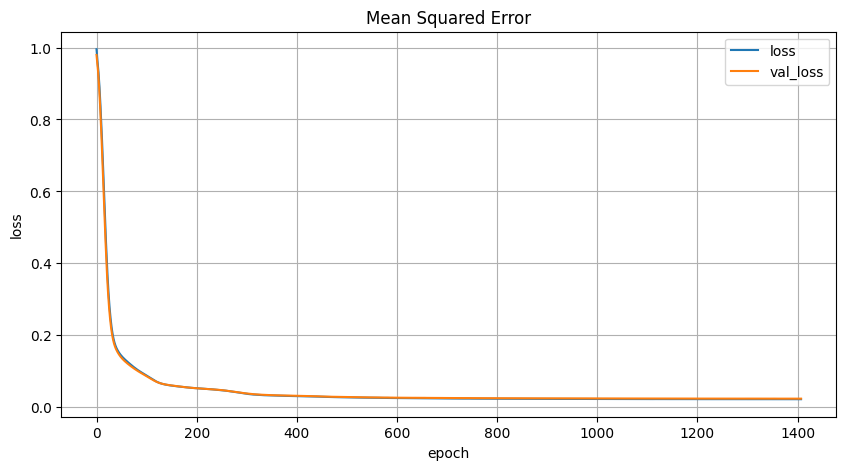

In [14]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(10,5))
plt.grid(),plt.xlabel('epoch'),plt.ylabel('loss'),plt.title('Mean Squared Error')
plt.show()

In [15]:
testing_results=ecg_dectector.evaluate(test_ds,verbose=0,return_dict=True)
print('Testing results:',testing_results)

Testing results: {'loss': 0.02371145784854889, 'mean_absolute_error': 0.10299346596002579, 'mean_squared_error': 0.02371145784854889}


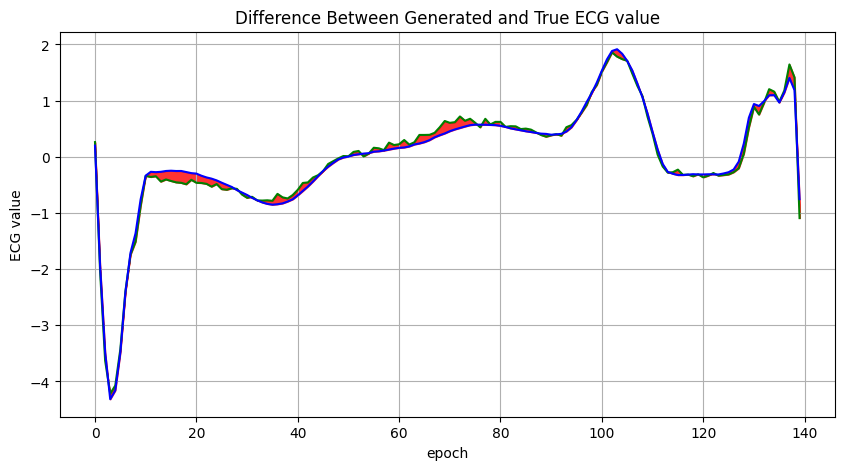

In [16]:
for samples,_ in test_ds.shuffle(buffer_size=buffer_size).take(1):break# take a batch of data for testing data
logits=ecg_dectector(samples)
plt.figure(figsize=(10,5))
plt.plot(samples[0],color='g',label='true sample')
plt.plot(logits[0],color='b',label='output sample')
plt.fill_between(range(len(samples[0])),samples[0],logits[0],color='red',alpha=0.8)
plt.grid(),plt.xlabel('epoch'),plt.ylabel('ECG value')
plt.title('Difference Between Generated and True ECG value')
plt.show()

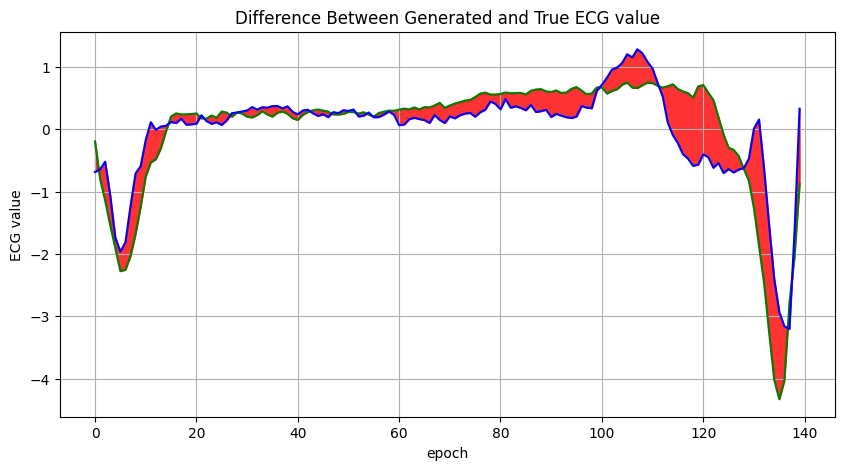

In [17]:
for samples in abnormal_ecg_ds.shuffle(buffer_size=buffer_size).take(1):break
logits=ecg_dectector(samples)
plt.figure(figsize=(10,5))
plt.plot(samples[0],color='g',label='true sample')
plt.plot(logits[0],color='b',label='output sample')
plt.fill_between(range(len(samples[0])),samples[0],logits[0],color='red',alpha=0.8)
plt.grid(),plt.xlabel('epoch'),plt.ylabel('ECG value')
plt.title('Difference Between Generated and True ECG value')
plt.show()

In [18]:
reconstructed_logits=ecg_dectector(abnormal_ecg+normal_ecg)
overall_loss=tf.keras.losses.mse(abnormal_ecg+normal_ecg,reconstructed_logits)

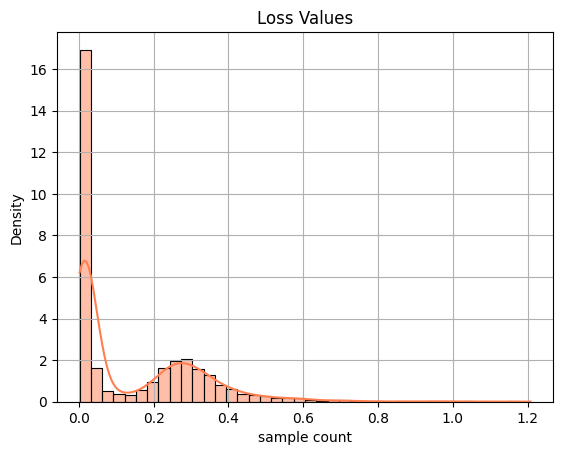

In [19]:
sns.histplot(x=overall_loss,bins='auto',color='coral',kde=True,stat='density')
plt.grid(),plt.xlabel('sample count'),plt.title('Loss Values')
plt.show()

In [20]:
threshold=tf.reduce_mean(overall_loss)+tf.math.reduce_std(overall_loss)
threshold

<tf.Tensor: shape=(), dtype=float32, numpy=0.31777978>

In [21]:
true_labels=len(abnormal_ecg)*[0]+len(normal_ecg)*[1]
predicted_labels=[(threshold<loss).numpy() for loss in list(overall_loss.numpy())]
total_correct_predictions=sum([true==predicted for true,predicted in zip(true_labels,
                                                                         predicted_labels)])
print('Model accuracy:',total_correct_predictions/(len(abnormal_ecg)+len(normal_ecg))*100)

Model accuracy: 25.230092036814728
